# A Solution to the [October 2014 Data Skeptic Podcast Contest](http://dataskeptic.com/blog/episodes/2014/contest)

On the Oct 7 2014 episode of Data Skeptic, Kyle announced a contest to predict the date on which the cumulative number of downloads of the Data Skeptic Podcast surpases 27,182. The only information given to make the prediciton are the following four data points:

```
##        dates dateNums downloads
## 1 2014-06-21        0       130
## 2 2014-07-31       40      2313
## 3 2014-08-30       70      6146
## 4 2014-10-04      105     13400
```

This notebook will predict the crossover date.

# Table of Contents
1. [Visualizing the Data](#Visualizing the Data)
2. [Model and Motivation](#Model and Motivation)
3. [Fitting Our Model to the Data](#Fitting Our Model to the Data)
4. [Making the prediciton](#Making the Prediciton)

# Visualizing the Data <a id="Visualizing the Data">

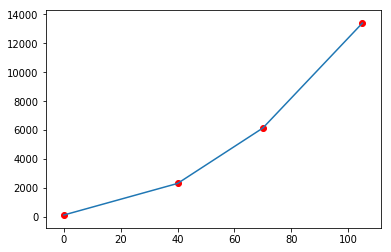

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
        
import matplotlib.pyplot as plt
import scipy.optimize as opt

df = pd.DataFrame([['2014-06-21', 0, 130],
                   ['2014-07-31', 40, 2313],
                   ['2014-08-30', 70, 6146],
                   ['2014-10-04', 105, 13400]], columns = ['dates', 'dateNums', 'downloads'])

plt.plot(df.dateNums, df.downloads)
plt.scatter(df.dateNums, df.downloads, color='red')
plt.show()

The shape of the data seems to suggest exponential growth.

# Model and Motivation <a id="Model and Motivation">
There is very little provided data to extrapolate from, so it is going to be important that we choose a model that is motivated by prior knowledge of the system as a whole. Consider the following observations: There is a finite number (at least, in the timeframe of the contest) of people that regularly listen to podcasts and who may be interested in a podcast like Data Skeptic. Furthermore, the more regular listeners there are, the greater the exposure the pocast gets through word of mouth, shares, reviews, etc. It follows, Then, that the number of regular listeners will have a tendency to grow exponentially, but is limited by an upper bound or ***carrying capacity***.

This description is consistent with the [Logistic Funciton](https://en.wikipedia.org/wiki/Logistic_function), so we'll write the number of regular listeners as a generalized logistic function:
$$\text{Listeners} = \frac{A}{1 + e^{-B(x-C)}}$$

We will make the assumption that the rate of podcast downloads is proportional to the number of listeners, so if $y$ is the function that describes the number of cumulative downloads over time, we can replace the number of listeners with $y$'s first derivative:

$$y' = \frac{A}{1 + e^{-B(x-C)}}$$

This yields a differential equation that can be trivially solved by integrating both sides:

$$y = A \left(x + \frac{\log\left(1 + e^{B (C - x)}\right)}{B}\right) + D$$

This will be the function we use to fit to our data with parameters $A$, $B$, $C$ and $D$

# Fitting Our Model to the Data <a id="Fitting Our Model to the Data">
First, define $y$ as a python function.

In [2]:
def func(x, A, B, C, D):
    x = np.float128(x) # perform calulation in 128bit to prevent overflow
    return np.float64(A * (x + np.log(1+np.exp(B*(C-x)))/B) + D)

## Initial paramters
We need a good starting point for the optimizer to fit the model properly. To acheive this, we will adapt the code found [here](https://bitbucket.org/zunzuncode/ramanspectroscopyfit/src/master/RamanSpectroscopyFit.py) which uses the differential evolution module from SciPy to find a good set of initial parameters

In [3]:
import warnings

from scipy.optimize import differential_evolution

xData = df.dateNums
yData = df.downloads
    
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    return np.sum((yData - func(xData, *parameterTuple)) ** 2)

def generate_Initial_Parameters():    
    parameterBounds = []
    
    # parameter bounds are selected with trial-and-error
    parameterBounds.append([0, 100]) # parameter bounds for A
    parameterBounds.append([0, 10]) # parameter bounds for B
    parameterBounds.append([0, 10]) # parameter bounds for C
    parameterBounds.append([-100, 10000]) # parameter bounds for D

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3, maxiter=10000)
    return result.x

# generate initial parameter values
initialParameters = generate_Initial_Parameters()

# print initial parameter values
print("Initial Parameters:")
for name, param in zip(['A','B','C','D'], initialParameters):
    print(name, ": ", param)

Initial Parameters:
A :  100.0
B :  4.964924986914076
C :  0.0
D :  118.60511085329257


## Performing the fit
We use SciPy's curve_fit to apply the method of least-squares.

In [4]:
from scipy.optimize import curve_fit
# curve fit the test data
fittedParameters, pcov = curve_fit(func, xData, yData, initialParameters)

print("Fitted Parameters")
for name, param in zip(['A','B','C','D'], fittedParameters):
    print(name, ": ", param)

Fitted Parameters
A :  292.67680820508997
B :  0.03616453117123982
C :  62.227760202803694
D :  -18893.248576270173


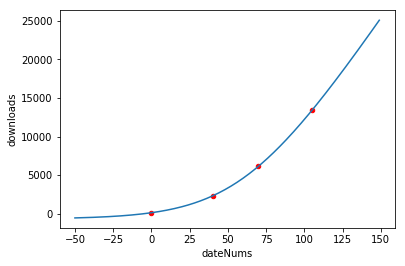

In [5]:
df.plot.scatter(1, 2, color='red')
plt.plot(range(-50, 150), func(range(-50,150), *fittedParameters))
plt.show()

The fit looks good!

# Making the Prediciton  <a id="Making the Prediciton">
Now that we have a working model, we can predict on what day the number of downloads will pass 27,182

The model predicts the number will be reached 156.52849309844194 days after 2014-06-21


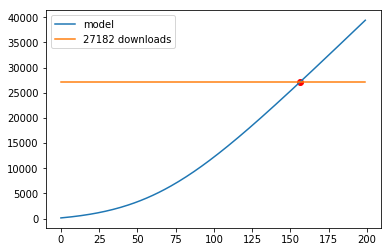

In [6]:
# find intersection
intersection = opt.fsolve(lambda x : func(x, *fittedParameters) - 27182, 0)
print("The model predicts the number will be reached", float(intersection), "days after 2014-06-21")

plt.plot(range(200), func(range(200), *fittedParameters), label='model')
plt.plot(range(200), [27182]*200, label='27182 downloads')
plt.scatter([intersection], func(intersection, *fittedParameters), color='red')
plt.legend()
plt.show()

To translate that to a date we'll use Python's `datetime` module

In [7]:
import datetime
start_date = datetime.datetime.strptime("2014-06-21", "%Y-%m-%d")
end_date = start_date + datetime.timedelta(days=float(intersection))

print("The crossover will occur at", end_date)

The crossover will occur at 2014-11-24 12:41:01.803705


How close was this prediciton? @DataSkeptic on Twitter [revealed the solution](https://twitter.com/DataSkeptic/status/544527949651648512) to be Nov 25, 2014, making my prediction only 1 day off.